In [3]:
import pandas as pd
from itertools import combinations
import numpy as np
from tqdm import tqdm

Note: This file made update base on Liaoliang's original method template. Did some change to concatenate results more conveniently.

## Clustering evaluation using Rand Index

In [4]:
# evaluation function with an example
# the truths are the list of arxiv categories for each paper, the preds are the cluster labels
# rand score modified to allow for multiple categories per paper

def modified_rand_score_vectorized(preds, truths):
    n = len(preds)
    
    # Convert predictions to a numpy array for faster operations
    preds = np.array(preds)
    
    # Prepare a label presence matrix
    unique_labels = sorted(set(label for sublist in truths for label in sublist))
    label_index = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Create a boolean matrix of size (n, number of unique labels)
    truth_matrix = np.zeros((n, len(unique_labels)), dtype=bool)
    for i, labels in enumerate(truths):
        truth_matrix[i, [label_index[label] for label in labels]] = True
    
    # Calculate pairwise matrix indicating shared label (the slowest part of the function))
    shared_label_matrix = np.dot(truth_matrix, truth_matrix.T) > 0
    
    # Calculate pairwise equal predictions
    same_pred = preds[:, None] == preds
    
    # Calculate TP, TN, FP, FN using vectorized operations
    TP = np.sum(np.logical_and(shared_label_matrix, same_pred))
    TN = np.sum(np.logical_and(~shared_label_matrix, ~same_pred))
    FP = np.sum(np.logical_and(~shared_label_matrix, same_pred))
    FN = np.sum(np.logical_and(shared_label_matrix, ~same_pred))

    # Correct for self-comparison (diagonal counts as True in both shared_label_matrix and same_pred)
    TP -= n
    
    # Calculate the Rand Index
    rand_index = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    return rand_index

# Example usage
preds = [1, 1, 2, 2]
truths = [['a', 'b'], ['a'], ['c'], ['c', 'd']]
print(modified_rand_score_vectorized(preds, truths))

1.0


##  Example usage with arxiv data

In [7]:
# function to add back the list of categories for each paper
def reorg_category_df(df_categories):
    data_ids, data_categories = [], []
    cur_id, cat = "", []
    data = df_categories.sort_values("id")

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        if cur_id != row[0]:
            # save the exising id's categories data to dictionary. if cur_id is "", it indicates the beginning of the loop, no prior records to save
            if cur_id != "":
                data_ids.append(cur_id)
                data_categories.append(",".join(cat))
                cur_id = row[0]
                cat = []
            else:
                cur_id = row[0]
        cat.append(row[1])

    df = pd.DataFrame.from_dict({"id": data_ids, 'categories': data_categories})

    return df

In [8]:
import os
evaluation_folder = os.getcwd() + "/evaluation"

# the data/arxiv-metadata-ext-category.csv file contains N rows of the same paper (same paper id) with N different categories
df_categories = pd.read_csv("data/arxiv-metadata-ext-category.csv",dtype={"id":object,"category_id":object})
# Reorganize to each row as one paper with a column containing the list of categories. Might take 1 to 3+ mins.
df_reorg_category = reorg_category_df(df_categories)

df_reorg_category.to_csv(evaluation_folder + "/reorg_category.csv")
print(f"Total {df_reorg_category.shape[0]} records. Have saved the file {evaluation_folder + '/reorg_category.csv'} into the data folder.")

100%|██████████| 4173480/4173480 [02:35<00:00, 26905.49it/s]


Total 2455221 records. Have saved the file c:\Users\Claud\Documents\ArXiv-Dataset-T14/evaluation/reorg_category.csv into the data folder.


In [10]:
def split_comma(input):
    try:
        return input.split(",")
    except:
        return []

### Concatenate All the Evaluation Results ###

In [13]:

avg_score, min_score, max_score, config = [], [], [], []

for method in ["_word2vec_", "_norm_word2vec_", "_tfidf_"]:
    # to speed up the evaluation, we sample random 10,000 papers 10 times and evaluate the clustering results based on the average score
    output_score = []
    for clusters in [10, 20, 30, 40, 50, 60]:
        for i in range(clusters):
            file_name = "kmeans" + method + str(clusters)
            df_clustering = pd.read_csv(evaluation_folder + "/" +file_name  + ".csv",dtype={"id":object})
            df_clustering = df_clustering.merge(df_reorg_category, how='left', on="id")
            df_clustering["categories_list"] = df_clustering["categories"].apply(lambda x: split_comma(x))

            df_clustering_filter = df_clustering[~df_clustering["categories"].isna()]
            df_sample = df_clustering_filter.sample(10000, random_state = i)
            score = modified_rand_score_vectorized(df_sample["topic_id"], df_sample["categories_list"])
            output_score.append(score)
            print(f"Config {file_name}'s seed: {i}, score: {score}")
    
        config.append(file_name)
        avg_score.append(np.mean(output_score))
        max_score.append(np.max(output_score))
        min_score.append(np.min(output_score))
    
        print(f"Config {config[-1]}'s Average Rand Index Score: {avg_score[-1]}\n\n")

Config kmeans_word2vec_10's seed: 0, score: 0.833264806480648
Config kmeans_word2vec_10's seed: 1, score: 0.8327624562456246
Config kmeans_word2vec_10's seed: 2, score: 0.8320647464746475
Config kmeans_word2vec_10's seed: 3, score: 0.8333911791179118
Config kmeans_word2vec_10's seed: 4, score: 0.8327034903490349
Config kmeans_word2vec_10's seed: 5, score: 0.8338910091009101
Config kmeans_word2vec_10's seed: 6, score: 0.8334168816881689
Config kmeans_word2vec_10's seed: 7, score: 0.8331502550255026
Config kmeans_word2vec_10's seed: 8, score: 0.832850205020502
Config kmeans_word2vec_10's seed: 9, score: 0.8339252325232523
Config kmeans_word2vec_10's Average Rand Index Score: 0.8331420262026203


Config kmeans_word2vec_20's seed: 0, score: 0.8700315231523152
Config kmeans_word2vec_20's seed: 1, score: 0.8694698669866987
Config kmeans_word2vec_20's seed: 2, score: 0.8689443744374438
Config kmeans_word2vec_20's seed: 3, score: 0.8695964796479648
Config kmeans_word2vec_20's seed: 4, score: 0

In [14]:
evaluation_result = pd.DataFrame({'config': config, 'avg_score': avg_score, 'max_score': max_score, 'min_score': min_score})

evaluation_result.to_csv(evaluation_folder + "/evaluation_result.csv", index = False)
display(evaluation_result)
                                 

,config,avg_score,max_score,min_score
0,kmeans_word2vec_10,0.833142,0.833925,0.832065
1,kmeans_word2vec_20,0.857150,0.871028,0.832065
2,kmeans_word2vec_30,0.869587,0.884625,0.832065
3,kmeans_word2vec_40,0.877116,0.891395,0.832065
4,kmeans_word2vec_50,0.881986,0.894634,0.832065
5,kmeans_word2vec_60,0.885304,0.896702,0.832065
6,kmeans_norm_word2vec_10,0.832993,0.833793,0.831893
7,kmeans_norm_word2vec_20,0.857975,0.872433,0.831893
8,kmeans_norm_word2vec_30,0.870303,0.885323,0.831893
9,kmeans_norm_word2vec_40,0.877405,0.890910,0.831893


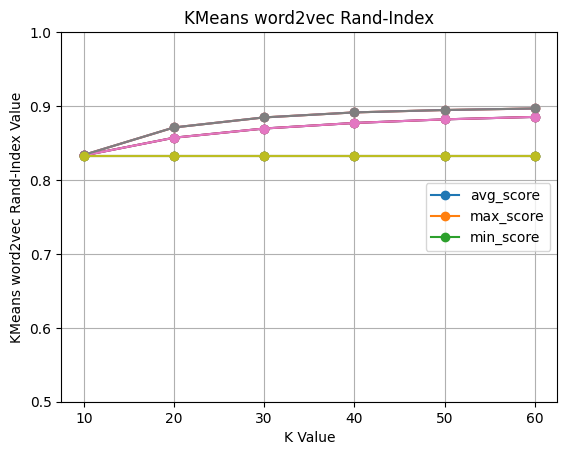

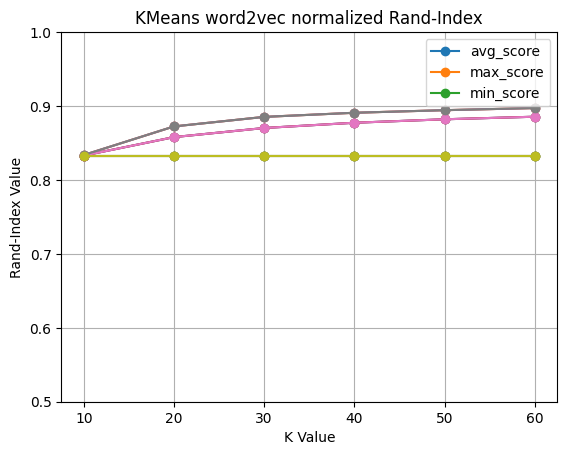

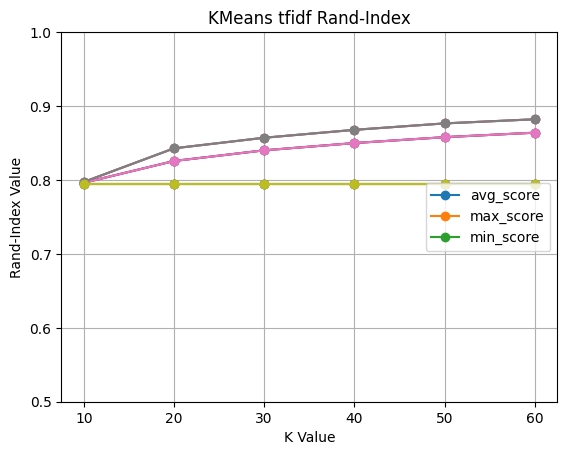

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
for i in range(3):
    plt.plot(np.arange(10, 70, 10), evaluation_result['avg_score'][:6], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['max_score'][:6], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['min_score'][:6], 'o-')

plt.xlabel('K Value')
plt.grid(True)
plt.ylim((0.5, 1))
plt.legend(['avg_score', 'max_score', 'min_score'])
plt.title('KMeans word2vec Rand-Index')
plt.legend(['avg_score', 'max_score', 'min_score'], loc ="right")
plt.ylabel('KMeans word2vec Rand-Index Value')

plt.figure()
for i in range(3):
    plt.plot(np.arange(10, 70, 10), evaluation_result['avg_score'][6:12], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['max_score'][6:12], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['min_score'][6:12], 'o-')

plt.xlabel('K Value')
plt.grid(True)
plt.ylim((0.5, 1))
plt.title('KMeans word2vec normalized Rand-Index')
plt.legend(['avg_score', 'max_score', 'min_score'], loc ="right")
plt.ylabel('Rand-Index Value')

plt.figure()
for i in range(3):
    plt.plot(np.arange(10, 70, 10), evaluation_result['avg_score'][12:18], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['max_score'][12:18], 'o-')
    plt.plot(np.arange(10, 70, 10), evaluation_result['min_score'][12:18], 'o-')

plt.xlabel('K Value')
plt.grid(True)
plt.ylim((0.5, 1))
plt.legend(['avg_score', 'max_score', 'min_score'], loc ="right")
plt.title('KMeans tfidf Rand-Index')
plt.ylabel('Rand-Index Value')


plt.show()

## Clustering evaluation using Silhouette Score (if possible)

In [ ]:
# X is a feature array and labels are predicted labels for each sample
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
# silhouette_score(X, labels)